<a href="https://colab.research.google.com/github/cluckey-smith/VinBigData_comp_repo/blob/data_processing/Data_Preprocessing_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import cv2
from google.colab import drive
drive.mount('/content/drive')
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from keras.layers import Convolution2D
from sklearn.model_selection import train_test_split
import keras.models as load
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
import time


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [3]:
df = pd.read_csv('./train.csv')
orig = df

In [4]:
train_files = os.listdir('/content/drive/MyDrive/Vin_big_data/train/')

In [5]:
df = df.pivot_table(index='image_id', columns='class_id', values='class_name', aggfunc=lambda x: len(x.unique())).fillna(0)

In [6]:
df.reset_index(inplace=True)


In [7]:
labels = []
img_name = []
img = []
classes = []

for i,r in df[:2000].iterrows():
  img_name.append(('/content/drive/MyDrive/Vin_big_data/train/') + r['image_id'] + '.png')
  image = load_img(('/content/drive/MyDrive/Vin_big_data/train/') + r['image_id'] + '.png')
  image = img_to_array(image)
  if len(image.shape) > 2:
    image = rgb2gray(image) # Not every image is in grayscale. This is converting them to it
  h,w = image.shape[:2]
  image = image / 255 # Converting our graycale image to values between 0 and 1
  img.append(image)
  classes.append(np.array(df.iloc[i][df.columns[1:]].values))


In [9]:
weights = compute_class_weight('balanced', np.unique(orig.class_id), orig.class_id[:2000])
cw = dict(zip(np.unique(orig.class_id), weights))

In [10]:
cw

{0: 0.5952380952380952,
 1: 16.666666666666668,
 2: 5.333333333333333,
 3: 0.7936507936507936,
 4: 8.88888888888889,
 5: 4.040404040404041,
 6: 3.508771929824561,
 7: 1.8518518518518519,
 8: 1.8779342723004695,
 9: 2.3391812865497075,
 10: 1.9047619047619047,
 11: 0.9876543209876543,
 12: 22.22222222222222,
 13: 0.9592326139088729,
 14: 0.1419950301739439}

# Transforming everything to numpy arrays

In [11]:
img = np.array(img)
img_name = np.array(img_name)


In [12]:
classes = np.asarray(classes).astype('float32')

In [13]:
split = train_test_split(img, classes,test_size=0.20, random_state=42)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]


# Needed to add a channel

In [14]:
trainImages = trainImages.reshape(len(trainImages), 512, 512, 1)
testImages = testImages.reshape(len(testImages), 512, 512, 1)

# Super duper basic CNN to just play around and get the feet wet

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(classes[1]), activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(trainImages, trainLabels, epochs=10, 
                    validation_data=(testImages, testLabels), class_weight=cw)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
20/50 [===========>..................] - ETA: 4:57 - loss: 0.3917 - accuracy: 0.0156

In [ ]:
model.save(('/content/drive/MyDrive/Vin_big_data/model_' + pd.to_datetime('now').strftime('%Y-%m-%d_%M_%H')))

# Plot our loss and perform a prediction or two

In [38]:
model = load.load_model('/content/drive/MyDrive/Vin_big_data/model_08_15_2021')

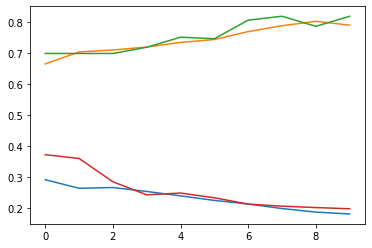

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])

In [99]:
x = load_img(('/content/drive/MyDrive/Vin_big_data/train/') + df.iloc[3903]['image_id'] + '.png')


In [100]:
x = img_to_array(x)

In [101]:
x = rgb2gray(x)
x = x/255

In [102]:
x = x.reshape(-1, 512,512,1)

In [103]:
model.predict(x)

array([[0.19250548, 0.04342401, 0.09916502, 0.09739822, 0.06486562,
        0.09231791, 0.08568898, 0.12827855, 0.09370884, 0.14104465,
        0.13799763, 0.2262997 , 0.03577763, 0.13670793, 0.7328673 ]],
      dtype=float32)